# Notebook 06 - Modelling and Evaluation v2

## Objectives

* Fit and evaluate a classification model that predicts whether or not an existing customer will default in the following month

## Inputs

* Combined data cleaning and feature engineering pipeline

## Outputs


* Test and train sets for the current split and target imbalance correction method
* Pipeline for modelling and hyperparameter optimisation
* Feature importance plot

## Additional Comments

* This notebook continues the work done in the previous notebook where initial modelling and hyperparameter optimisation was conducted. Different techniques are tried here in an attempt to improve model performance.

---

# Change working directory

* This notebook is stored in the `jupyter_notebooks` subfolder
* The current working directory therefore needs to be changed to the workspace, i.e., the working directory needs to be changed from the current folder to its parent folder

Firstly, the current directory is accessed with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default\\jupyter_notebooks'

Next, the working directory is set as the parent of the current `jupyter_notebooks` directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* This allows access to all the files and folders within the workspace, rather than solely those within the `jupyter_notebooks` directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Finally, confirm that the new current directory has been successfully set

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default'

---

# Load data and restate pipelines

The data is loaded from the outputs/datasets/collection folder:

In [4]:
import pandas as pd
df = pd.read_csv('outputs/datasets/collection/credit_card_data.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Next, we restate our existing data cleaning and feature engineering pipeline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder


def rename_columns(X):
    X.columns = ['credit_limit', 'sex', 'education', 'marital_status',
                 'age', 'late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr', 'bill_sep', 'bill_aug',
                 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr',
                 'prev_payment_sep', 'prev_payment_aug',
                 'prev_payment_jul', 'prev_payment_jun',
                 'prev_payment_may', 'prev_payment_apr',
                 'default_next_month']
    return X


def clean_categorical_data(X):
    sex_mapping = {1: "male", 2: "female"}
    education_mapping = {1: "graduate school", 2: "university", 3: "high school", 4: "other", 5: "unknown", 6: "unknown"}
    marital_status_mapping = {0: "unknown", 1: "married", 2: "single", 3: "other"}
    X['sex'] = X['sex'].replace(sex_mapping)
    X['education'] = X['education'].replace(education_mapping)
    X['marital_status'] = X['marital_status'].replace(marital_status_mapping)
    return X


def default_summary(X):
    X['any_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].gt(0).any(axis=1).astype(int)
    X['total_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].clip(lower=0).sum(axis=1)
    X['greatest_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].clip(lower=0).max(axis=1)
    return X


def ordinal_encode_education(X):
    X['education'] = X['education'].map(education_map)
    X['education'] = X['education'].fillna(0)
    return X

variables_ohe = ['sex', 'marital_status']

education_map = {
    '0': 0,
    'other': 0,
    'unknown': 0,
    'high school': 1,
    'university': 2,
    'graduate school': 3
}

data_cleaning_and_feature_engineering_pipeline = Pipeline([
      ('drop',  DropFeatures(features_to_drop=['ID'])),
      ('rename_columns', FunctionTransformer(rename_columns, validate=False)),
      ('clean_categorical_data', FunctionTransformer(clean_categorical_data)),
      ('add_default_summary', FunctionTransformer(default_summary)),
      ('one_hot_encode', OneHotEncoder(variables=variables_ohe, drop_last=True)),
      ('ordinal_encode', FunctionTransformer(ordinal_encode_education)),
      ('drop_after_cleaning',  DropFeatures(features_to_drop=['late_sep', 'late_aug', 'late_jun',
                                               'late_may', 'late_apr', 'bill_aug', 
                                               'bill_jul', 'bill_jun', 'bill_may', 
                                               'bill_apr', 'any_default', 'greatest_default',
                                               'marital_status_married'])),
])

As well as our ML pipeline for modelling and hyperparameter optimisation:

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


And our custom class for hyperparameter optimisation, taken from CI's WP02:

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


---

# Prepare Data for Modelling

## Apply data cleaning and feature engineering pipeline

As in the previous notebook, we apply the data cleaning and feature engineering pipeline:

In [8]:
df = data_cleaning_and_feature_engineering_pipeline.fit_transform(df)
df.head()

,credit_limit,education,age,late_jul,bill_sep,prev_payment_sep,prev_payment_aug,prev_payment_jul,prev_payment_jun,prev_payment_may,prev_payment_apr,default_next_month,total_default,sex_female,marital_status_single,marital_status_other
0,20000.0,2.0,24,-1,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,1,4,1,0,0
1,120000.0,2.0,26,0,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,4,1,1,0
2,90000.0,2.0,34,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,1,1,0
3,50000.0,2.0,37,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0,1,0,0
4,50000.0,2.0,57,-1,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,0,0,0,0


## Split data into train and test set

Split train and test set. Note that by keeping `random_state` the same value as in the previous notebook, we can be sure to split the data in exactly the same way.
* We inspect the shape of each of `X_train`, `y_train`, `X_test` and `y_test` as a check that the split has worked correctly

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['default_next_month'], axis=1),
    df['default_next_month'],
    test_size=0.2,
    random_state=42,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(24000, 15) (24000,) (6000, 15) (6000,)


In [10]:
y_train.head()

21753    0
251      0
22941    0
618      0
17090    0
Name: default_next_month, dtype: int64

## Handle Target Imbalance

As before, we verify the distribution of the train set target:

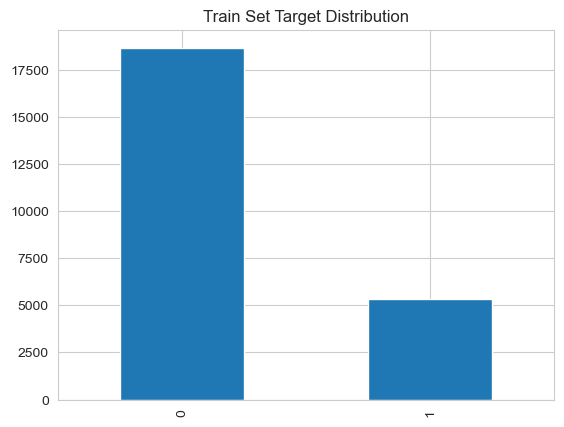

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

As before, we see that the train set is imbalanced.
* Previously, we applied SMOTE to the train set to fix this.
* However, we noted that this can increase the chance of overfitting the model, since using SMOTE increases the presence of characteristics in the dataset that were initially only applicable to a relatively small number of observations.
* The models in the previous notebook were all overfitting to some degree, and this was only improved to a limited extent by hyperparameter tuning.
* This time, we will therefore try undersampling the majority class as a method to address this.

`RandomUnderSampler` is used to undersample the majority class:

In [12]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy="not minority", random_state=0)
X_train, y_train = undersample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10646, 15) (10646,) (6000, 15) (6000,)


We then check the train set target distribution again after oversampling. An equal distribution is now seen:

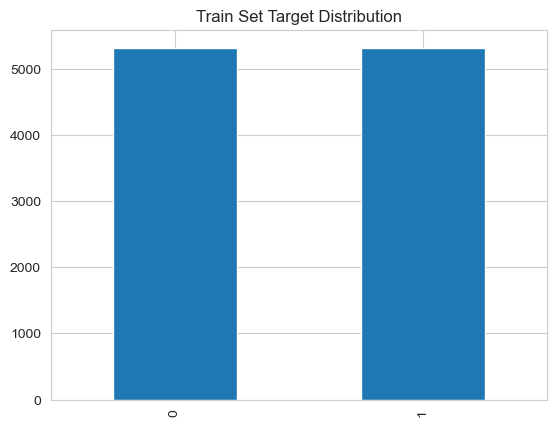

In [13]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

---

# Train the ML pipeline to predict default in the following month

## Find the most suitable algorithm for the data

We now repeat the processes from the previous notebook. First, we want to find the most suitable algorithm for the data by testing multiple algorithms using their default hyperparameters (as previously noted, the empty dictionaries in `params_quick_search` mean that the default hyperparameters will be used).

In [14]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "BernoulliNBClassifier": BernoulliNB(),
    "LinearSVCClassifier": LinearSVC(random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "BernoulliNBClassifier": {},
    "LinearSVCClassifier": {}
}


We now run GridSearch CV to identify the best performing algorithms for the data:

In [15]:
from sklearn.metrics import make_scorer, f1_score
f1_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
f1_search.fit(X_train, y_train,
           scoring =  make_scorer(f1_score),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for BernoulliNBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LinearSVCClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Now we can check the results:

In [16]:
import numpy as np
f1_grid_search_summary, grid_search_pipelines = f1_search.score_summary(sort_by='mean_score')
f1_grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
4,GradientBoostingClassifier,0.671135,0.683448,0.701689,0.011908
6,AdaBoostClassifier,0.67042,0.682432,0.692969,0.008438
1,XGBClassifier,0.67122,0.681415,0.689518,0.00696
3,RandomForestClassifier,0.672934,0.678131,0.684739,0.005389
5,ExtraTreesClassifier,0.668339,0.675858,0.687898,0.007283
7,BernoulliNBClassifier,0.637037,0.64612,0.653093,0.005626
0,LogisticRegression,0.630243,0.639209,0.6469,0.006525
8,LinearSVCClassifier,0.616949,0.629242,0.636364,0.007352
2,DecisionTreeClassifier,0.602817,0.615722,0.628678,0.010061


We see that the top five algorithms are all performing fairly similarly, with a `mean_score` between 0.675 and 0.684. To start with, given limited processing capacity, we will consider a range of hyperparameters for the top two, `GradientBoostingClassifier` and `AdaBoostClassifier`.

We are already familiar with `GradientBoostingClassifier` from the previous notebook and we use the same values for hyperparameter tuning as those considered in the previous iteration.

`AdaBoostClassifier`, as noted in its [online documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), is "a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases".
* It has a limited number of hyperparameters that can be tuned, so not as many hyperparameters appear in its `params_search` below.
* Similarly to in the other algorithms, `n_estimators` controls the number of weak learners (decision trees) to be used in the ensemble. Increasing the number of estimators can improve model performance, but it also increases the computational cost. We begin with values of 25, 50, 80 and 150.
    - Note that 25 has been removed in an attempt to fix the `UserWarning: One or more of the test scores are non-finite` error
* `learning_rate` determines the contribution of each weak learner to the final prediction. A lower learning rate typically requires more estimators to achieve similar performance. Here we consider values of 0.1, 1 and 2.
* `algorithm` determines the boosting algorithm used. The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations, but we consider both here.
* The `estimator` parameter determines the base estimator from which the boosted ensemble is built. Here we consider `DecisionTreeClassifier`, `RandomForestClassifier` and `ExtraTreesClassifier` to cover a range of possibilities.
    - Instances of the base estimators are created separately and then passed to `AdaBoostClassifier`.

In [20]:
estimator_1 = DecisionTreeClassifier()
estimator_2 = RandomForestClassifier()
estimator_3 = ExtraTreesClassifier()

models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
}

params_search = {
    "AdaBoostClassifier":{
      'model__n_estimators': [25, 50, 80],
      'model__learning_rate':[0.1, 1, 2],
      'model__algorithm': ['SAMME', 'SAMME.R'],
      'model__base_estimator': [estimator_1, estimator_2, estimator_3]
    },
    "GradientBoostingClassifier":{
      'model__n_estimators': [100, 50, 140],
      'model__learning_rate':[0.1, 0.01, 0.001],
      'model__max_depth': [3, 15, None],
      'model__min_samples_split': [2, 25, 50],
      'model__min_samples_leaf': [1, 25, 50],
      'model__max_leaf_nodes': [None, 25, 50]
    },
  }

In [21]:
detail_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
detail_search.fit(X_train, y_train,
           scoring =  make_scorer(f1_score),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


In [22]:
grid_search_summary, grid_search_pipelines = detail_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__algorithm,model__base_estimator,model__learning_rate,model__n_estimators,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split
586,GradientBoostingClassifier,0.684576,0.69866,0.704663,0.007206,NaN,NaN,0.001,50,3,25,50,2
616,GradientBoostingClassifier,0.684576,0.69866,0.704663,0.007206,NaN,NaN,0.001,50,3,50,50,25
589,GradientBoostingClassifier,0.684576,0.69866,0.704663,0.007206,NaN,NaN,0.001,50,3,25,50,25
565,GradientBoostingClassifier,0.684576,0.69866,0.704663,0.007206,NaN,NaN,0.001,50,3,None,50,50
562,GradientBoostingClassifier,0.684576,0.69866,0.704663,0.007206,NaN,NaN,0.001,50,3,None,50,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,GradientBoostingClassifier,0.60232,0.613963,0.626281,0.009807,NaN,NaN,0.001,50,None,None,1,2
702,GradientBoostingClassifier,0.601392,0.613791,0.626613,0.009825,NaN,NaN,0.001,100,None,None,1,2
461,GradientBoostingClassifier,0.60232,0.613712,0.625673,0.010005,NaN,NaN,0.01,140,None,None,1,2
7,AdaBoostClassifier,0.574468,0.610566,0.639456,0.023883,SAMME,DecisionTreeClassifier(),2,50,NaN,NaN,NaN,NaN


In [23]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingClassifier'

In [24]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.001,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [25]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            min_samples_leaf=50,
                                            n_estimators=50, random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['total_default', 'bill_sep']


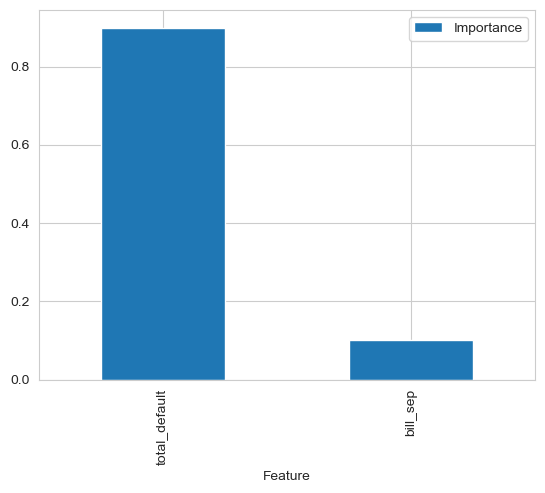

In [26]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [27]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


In [28]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Default', 'Default'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Default Actual Default
Prediction No Default              3610           1513
Prediction Default                 1713           3810


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.70      0.68      0.69      5323
     Default       0.69      0.72      0.70      5323

    accuracy                           0.70     10646
   macro avg       0.70      0.70      0.70     10646
weighted avg       0.70      0.70      0.70     10646
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Default Actual Default
Prediction No Default              3193            391
Prediction Default                 1494            922


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.89      0.68      0.77      4687
     Default       0.38      0.70      0.49      1313

    accuracy 

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [19]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block (2852421808.py, line 5)